### Results

This notebook contains visualizations for the results csv

For varying instances or population sizes:
- Instance size x Speedup
- Population size x Speedup
- Threads x Speedup
- Threads x Efficiency
- Overhead bars

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
project_root = os.path.abspath('..')
data_path = os.path.join(project_root, 'results', 'data.csv')

In [3]:
df = pd.read_csv(data_path)
df.head()

,instance,size,population_size,mode,threads,time_ms,best_distance
0,a280,280,50,sequential,1,1703.9350,2717.7451
1,a280,280,50,sequential,1,1779.9601,2726.7964
2,a280,280,50,sequential,1,1681.9278,2719.7187
3,a280,280,50,parallel,1,1674.2522,2735.0879
4,a280,280,50,parallel,1,1654.6682,2718.3343


In [4]:
instances = df['instance'].unique()
pop_sizes = df['population_size'].unique()
thread_counts = sorted(df[df['mode'] == 'parallel']['threads'].unique())

In [ ]:
grouped = df.groupby(['instance', 'population_size', 'mode', 'threads'], sort=False).agg({
    'time_ms': 'mean',
    'best_distance': 'mean'
}).reset_index()

sequential_baselines = grouped[grouped['mode'] == 'sequential'][['instance', 'population_size', 'time_ms']]
sequential_baselines = sequential_baselines.rename(columns={'time_ms': 'sequential_time'})

grouped = grouped.merge(
    sequential_baselines,
    on=['instance', 'population_size'],
    how='left'
)

grouped['speedup'] = grouped['sequential_time'] / grouped['time_ms']
grouped['efficiency'] = (grouped['speedup'] / grouped['threads']) * 100
grouped['ideal_time'] = grouped['sequential_time'] / grouped['threads']
grouped['overhead'] = grouped['time_ms'] - grouped['ideal_time']

# grouped['relative_time'] = grouped['time_ms'] / grouped['sequential_time']

grouped.head()

,instance,population_size,mode,threads,time_ms,best_distance,sequential_time,speedup,efficiency,ideal_time,overhead,relative_time
0,a280,50,sequential,1,1721.940967,2721.420067,1721.940967,1.000000,100.000000,1721.940967,0.000000,1.000000
1,a280,50,parallel,1,1658.703333,2739.823967,1721.940967,1.038125,103.812474,1721.940967,-63.237633,0.963275
2,a280,50,parallel,2,1048.208100,2760.203933,1721.940967,1.642747,82.137362,860.970483,187.237617,0.608736
3,a280,50,parallel,4,709.414400,2749.521667,1721.940967,2.427271,60.681774,430.485242,278.929158,0.411985
4,a280,50,parallel,8,727.469733,2762.006500,1721.940967,2.367028,29.587846,215.242621,512.227112,0.422471


In [20]:
grouped_50pop = grouped[grouped['population_size'] == 50]
parallel_grouped_50pop = grouped_50pop[grouped_50pop['mode'] == 'parallel']

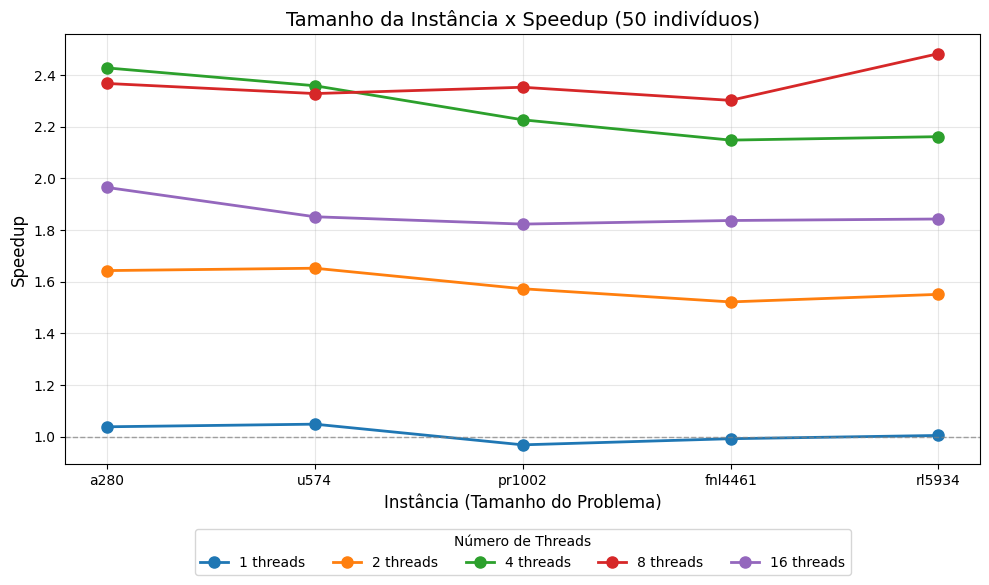

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

for t in thread_counts:
    thread_data = parallel_grouped_50pop[parallel_grouped_50pop['threads'] == t]
    
    ax.plot(
        thread_data['instance'],
        thread_data['speedup'],
        marker='o',
        linewidth=2,
        markersize=8,
        label=f'{t} threads'
    )

ax.set_xlabel('Instância (Tamanho do Problema)', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Tamanho da Instância x Speedup (50 indivíduos)', fontsize=14)

ax.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.grid(True, alpha=0.3)
ax.legend(
    title='Número de Threads',
    ncol=len(thread_counts),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15), 
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


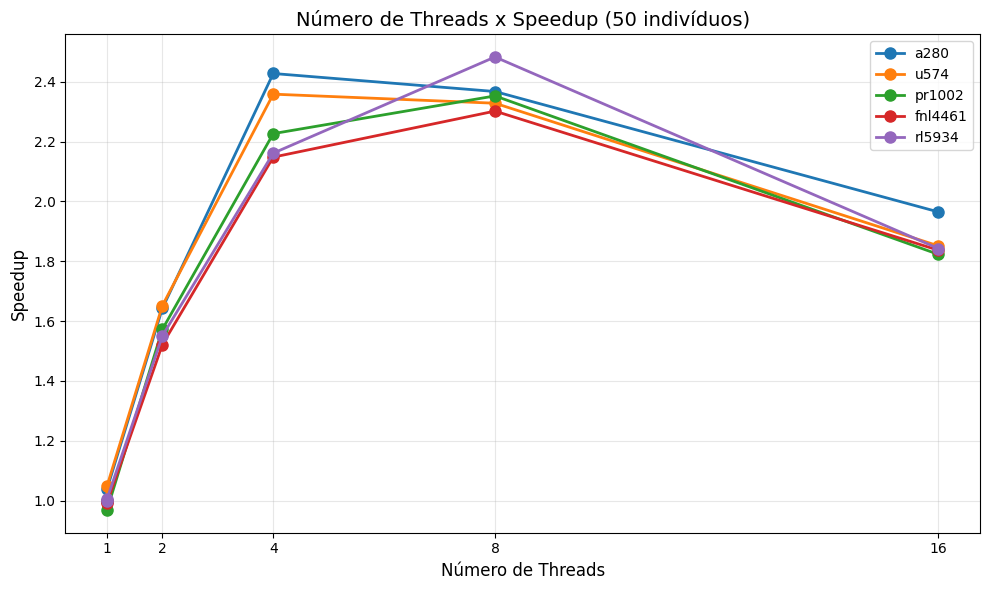

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = grouped_50pop[grouped_50pop['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['speedup'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Número de Threads x Speedup (50 indivíduos)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

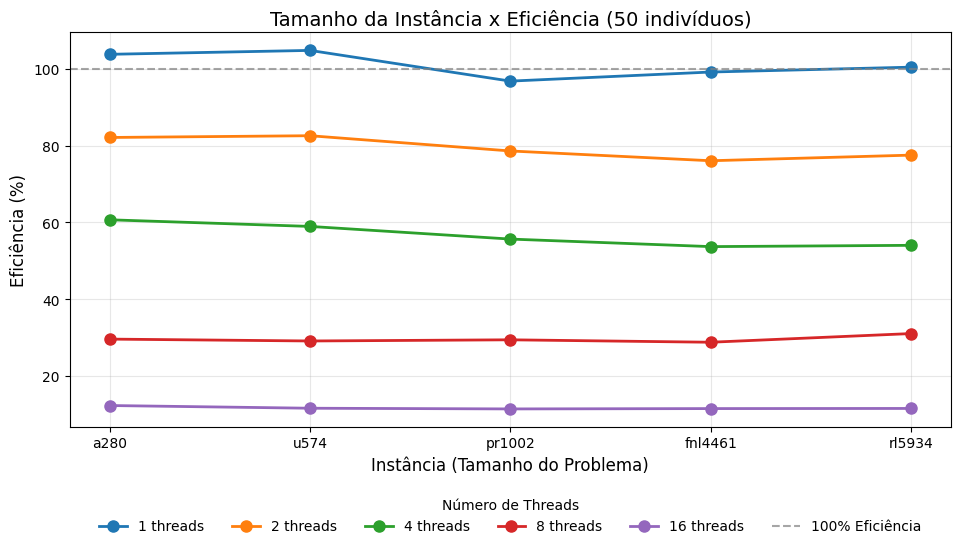

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

for t in thread_counts:
    thread_data = parallel_grouped_50pop[parallel_grouped_50pop['threads'] == t]
    
    ax.plot(
        thread_data['instance'],
        thread_data['efficiency'],
        marker='o',
        linewidth=2,
        markersize=8,
        label=f'{t} threads'
    )

ax.axhline(y=100, linestyle='--', linewidth=1.5, color='gray', alpha=0.7, label='100% Eficiência')

ax.set_xlabel('Instância (Tamanho do Problema)', fontsize=12)
ax.set_ylabel('Eficiência (%)', fontsize=12)
ax.set_title('Tamanho da Instância x Eficiência (50 indivíduos)', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(title='Número de Threads', ncol=len(thread_counts)+1, loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

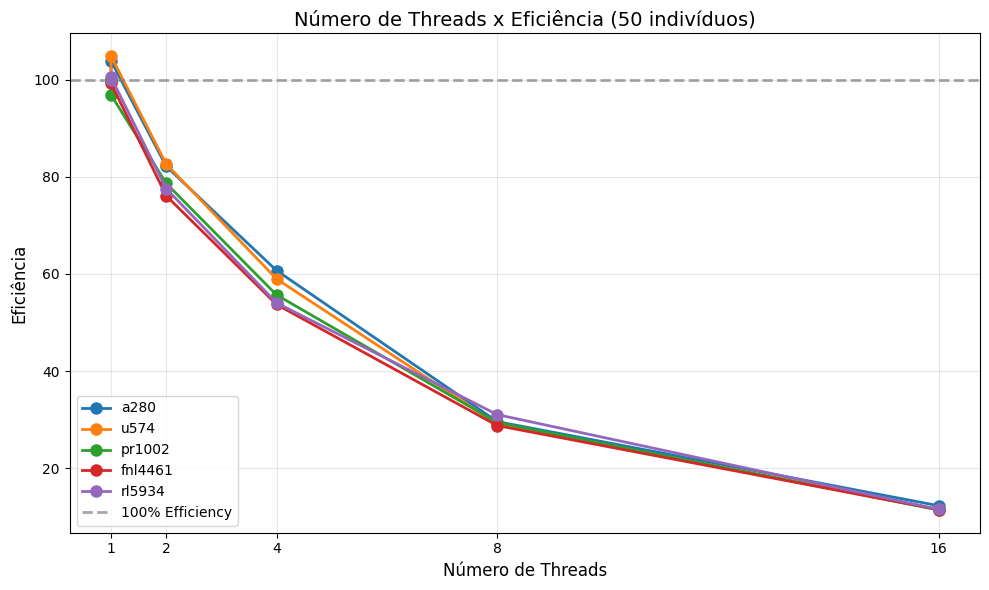

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for instance in instances:
    instance_data = grouped_50pop[grouped_50pop['instance'] == instance]
    
    ax.plot(instance_data['threads'], 
            instance_data['efficiency'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=instance)
    
ax.axhline(y=100, 
        linestyle='--', 
        linewidth=2,
        color='gray', 
        alpha=0.7,
        label='100% Efficiency')

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Eficiência', fontsize=12)
ax.set_title('Número de Threads x Eficiência (50 indivíduos)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

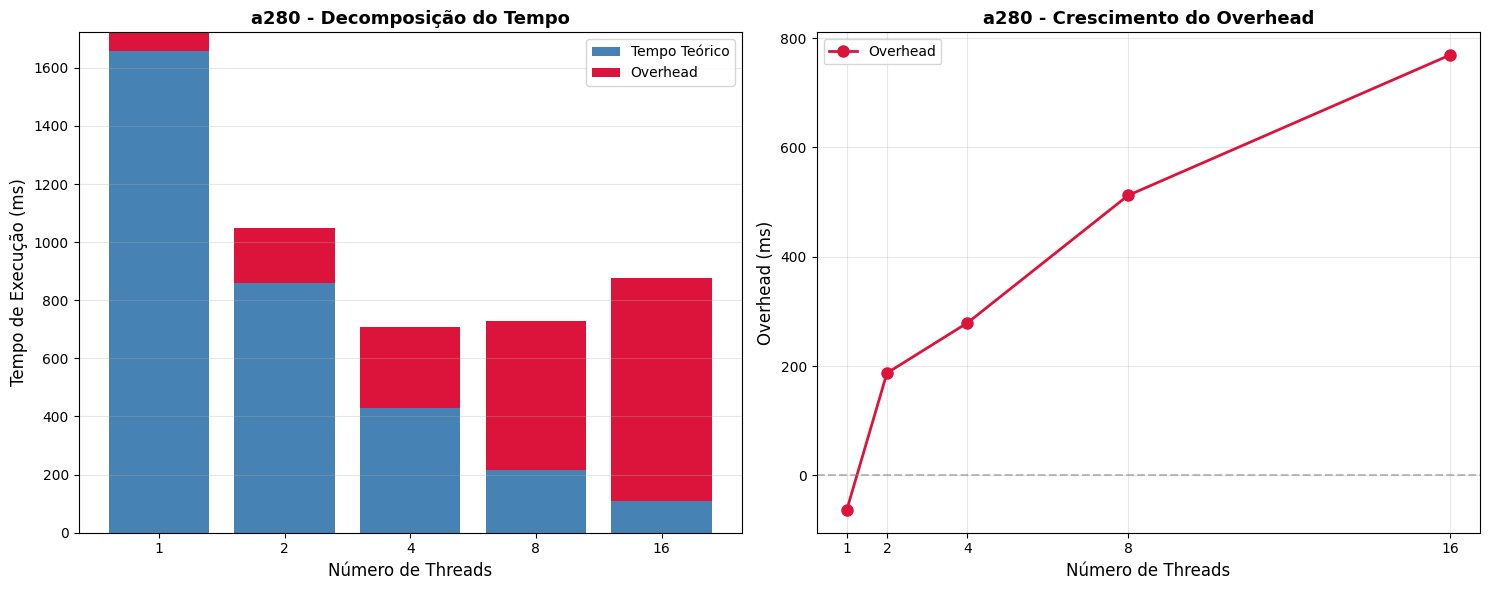

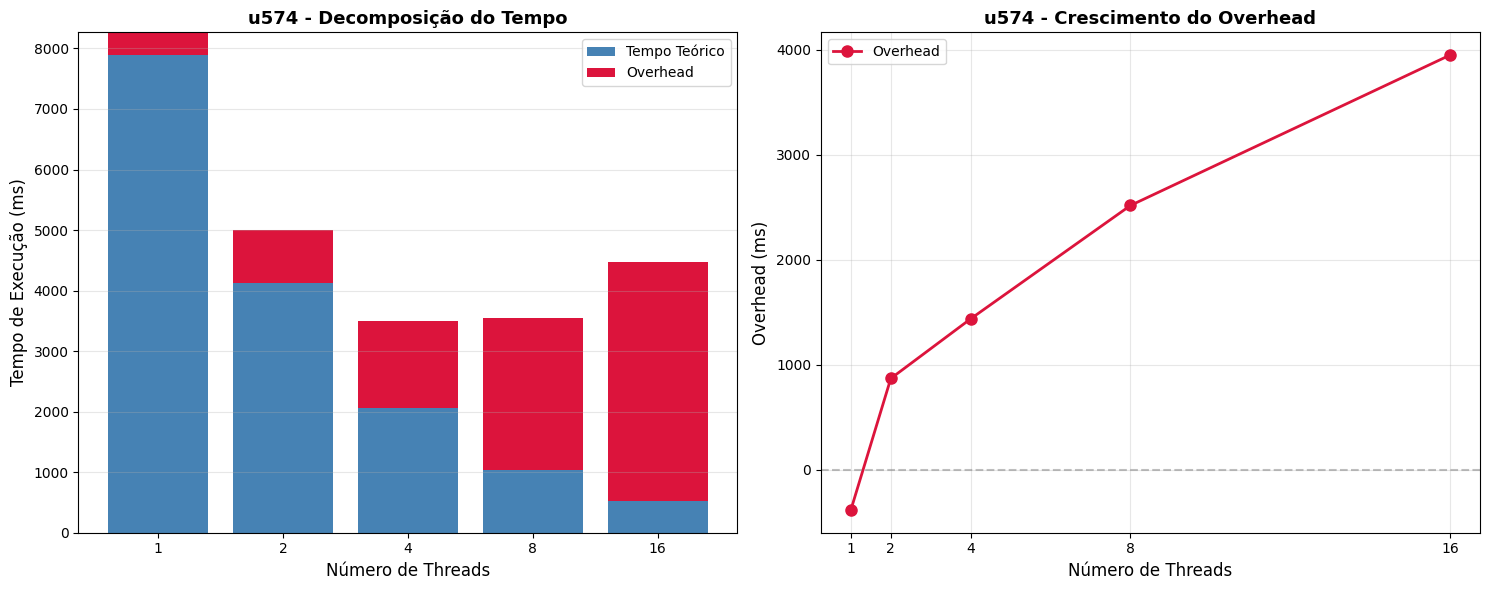

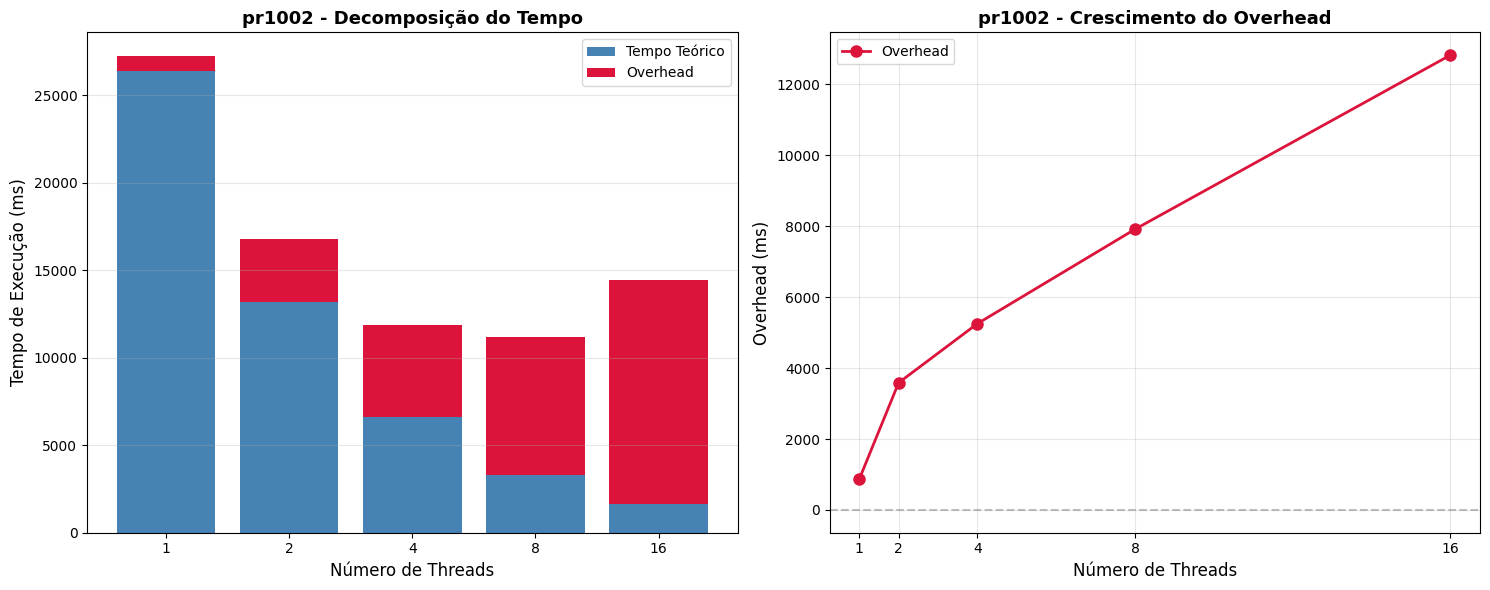

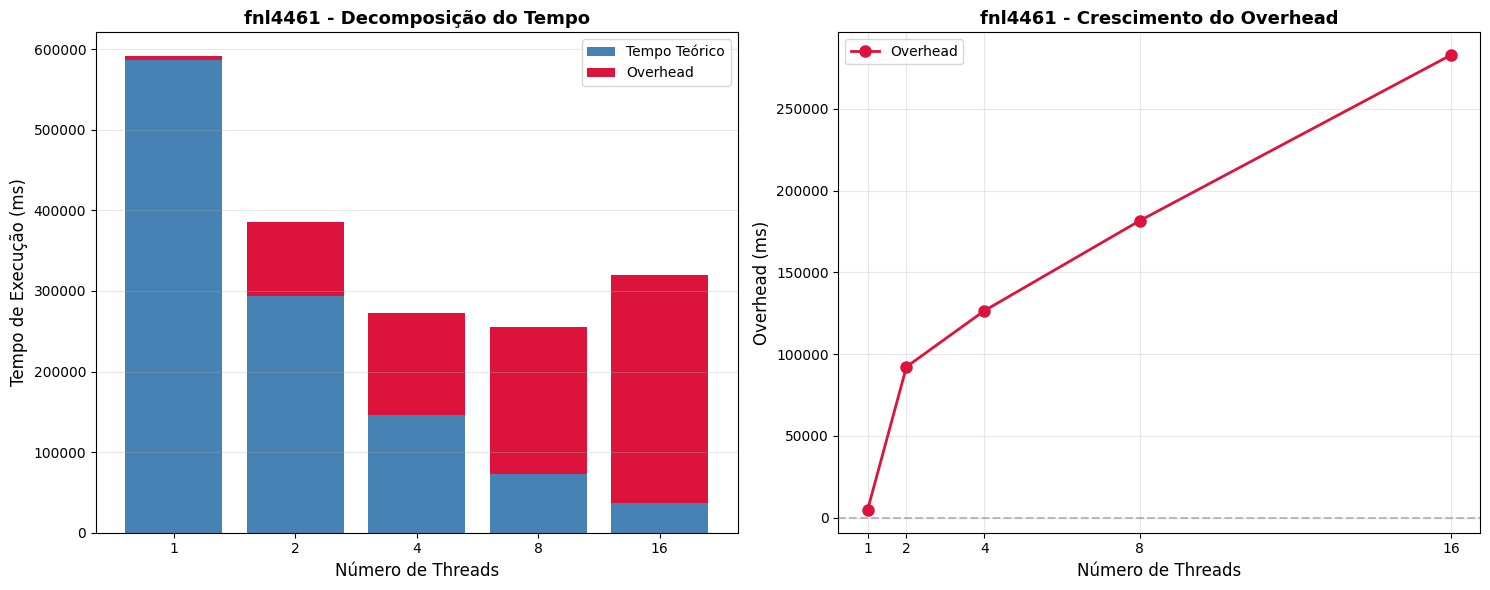

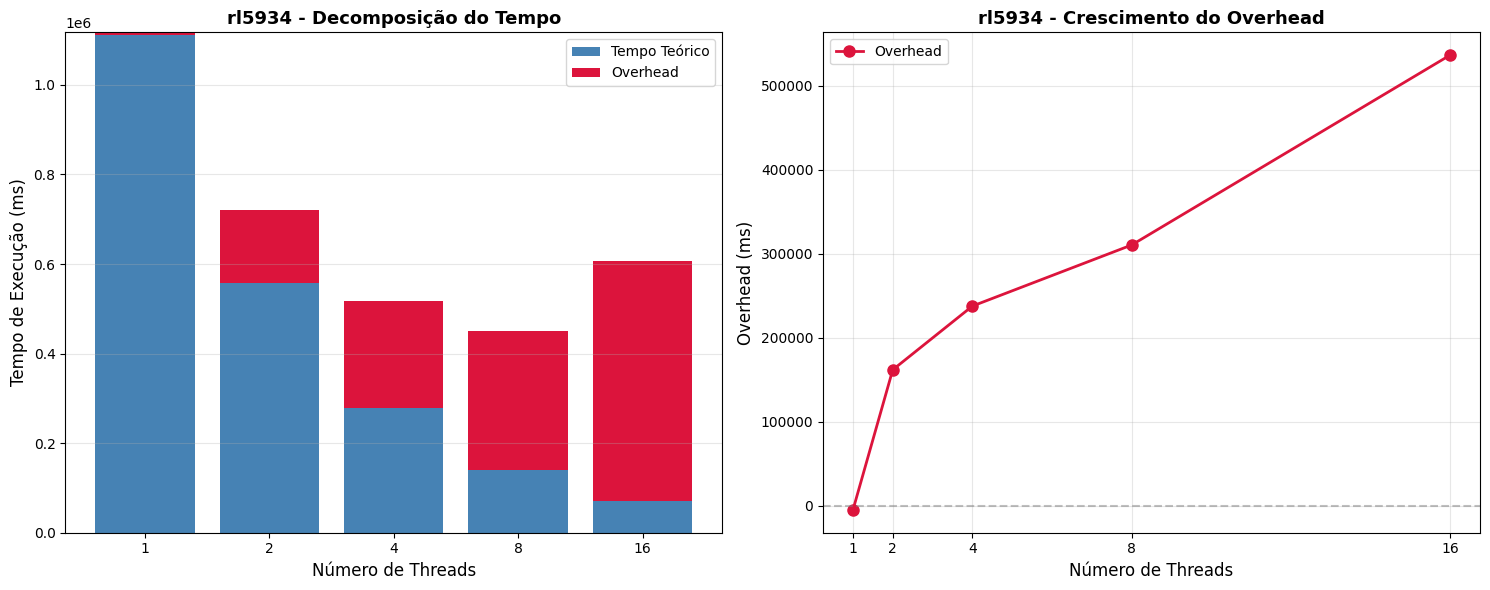

In [ ]:
for instance in instances:
    instance_data = parallel_grouped_50pop[parallel_grouped_50pop['instance'] == instance]
    
    if len(instance_data) == 0:
        print(f"Skipping {instance}: no parallel data")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    threads = instance_data['threads'].values
    ideal = instance_data['ideal_time'].values
    overhead = instance_data['overhead'].values
    
    x_pos = range(len(threads))
    
    # ===== PLOT 1: Stacked Bar Chart =====
    ax1.bar(x_pos, ideal, label='Tempo Teórico', color='steelblue')
    ax1.bar(x_pos, overhead, bottom=ideal, label='Overhead', color='crimson')
    
    ax1.set_xlabel('Número de Threads', fontsize=12)
    ax1.set_ylabel('Tempo de Execução (ms)', fontsize=12)
    ax1.set_title(f'{instance} - Decomposição do Tempo', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(threads)
    
    # ===== PLOT 2: Overhead Line Graph =====
    ax2.plot(threads, overhead,
             marker='o',
             linewidth=2,
             markersize=8,
             color='crimson',
             label='Overhead')
    
    ax2.set_xlabel('Número de Threads', fontsize=12)
    ax2.set_ylabel('Overhead (ms)', fontsize=12)
    ax2.set_title(f'{instance} - Crescimento do Overhead', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(threads)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [24]:
grouped_a280 = grouped[grouped['instance'] == 'a280']
parallel_grouped_a280 = grouped_a280[grouped_a280['mode'] == 'parallel']

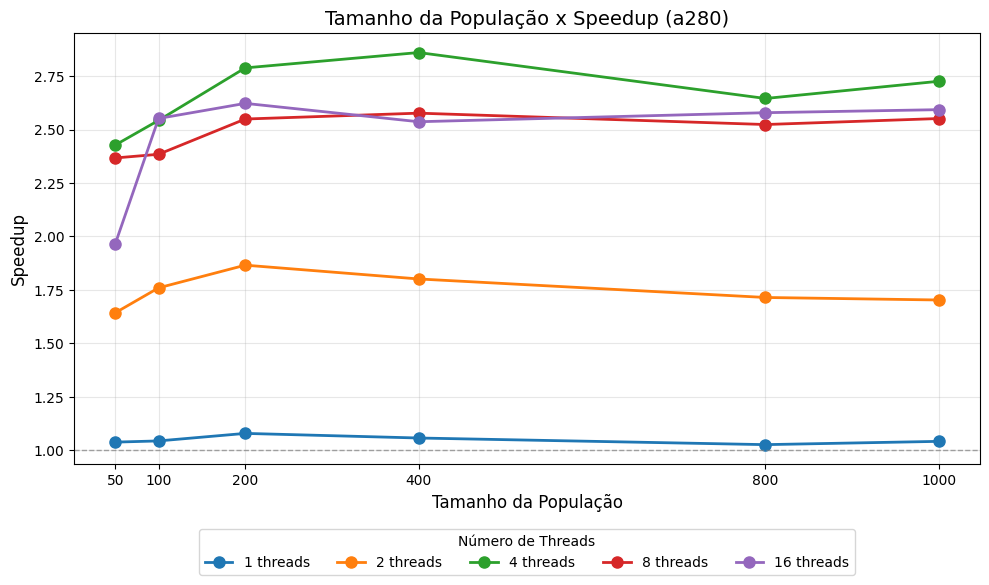

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

for t in thread_counts:
    thread_data = parallel_grouped_a280[parallel_grouped_a280['threads'] == t]
    
    ax.plot(
        thread_data['population_size'],
        thread_data['speedup'],
        marker='o',
        linewidth=2,
        markersize=8,
        label=f'{t} threads'
    )

ax.set_xlabel('Tamanho da População', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Tamanho da População x Speedup (a280)', fontsize=14)

ax.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.grid(True, alpha=0.3)
ax.legend(
    title='Número de Threads',
    ncol=len(thread_counts),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15), 
    borderaxespad=0.
)
ax.set_xticks(sorted(parallel_grouped_a280['population_size'].unique()))

plt.tight_layout()
plt.show()

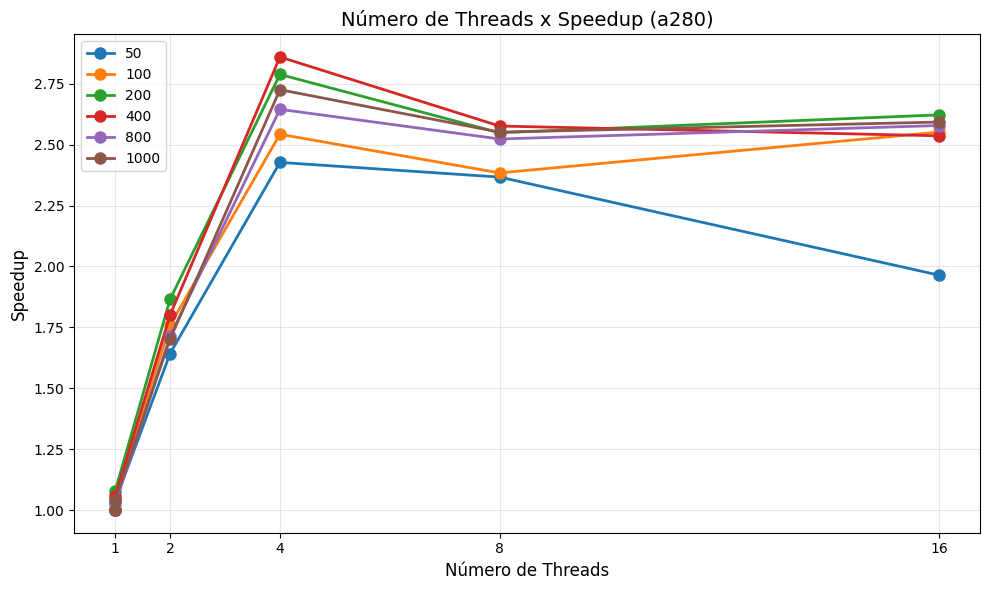

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

for population_size in pop_sizes:
    pop_data = grouped_a280[grouped_a280['population_size'] == population_size]
    
    ax.plot(pop_data['threads'], 
            pop_data['speedup'],
            marker='o',
            linewidth=2,
            markersize=8,
            label=population_size)

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Número de Threads x Speedup (a280)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

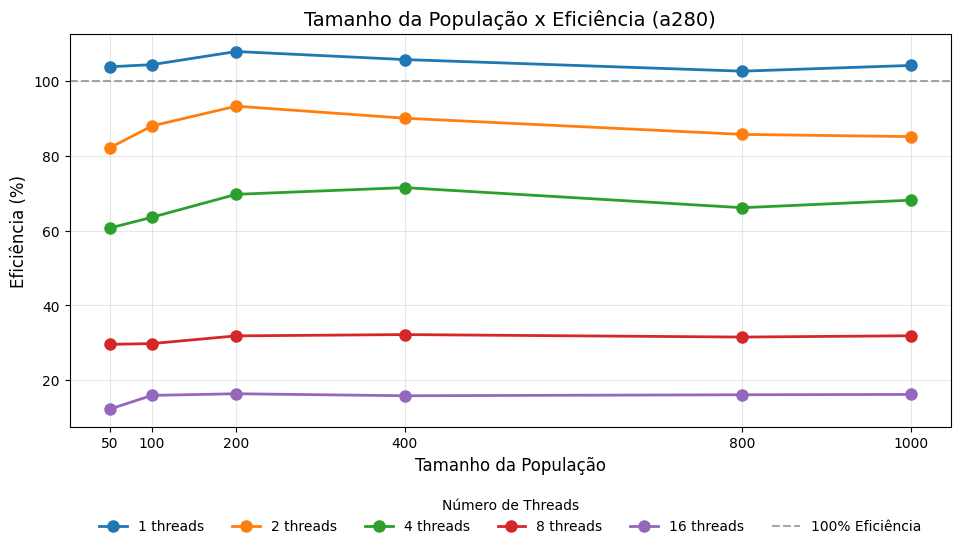

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

for t in thread_counts:
    thread_data = parallel_grouped_a280[parallel_grouped_a280['threads'] == t]
    
    ax.plot(
        thread_data['population_size'],
        thread_data['efficiency'],
        marker='o',
        linewidth=2,
        markersize=8,
        label=f'{t} threads'
    )

ax.axhline(y=100, linestyle='--', linewidth=1.5, color='gray', alpha=0.7, label='100% Eficiência')

ax.set_xlabel('Tamanho da População', fontsize=12)
ax.set_ylabel('Eficiência (%)', fontsize=12)
ax.set_title('Tamanho da População x Eficiência (a280)', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(title='Número de Threads', ncol=len(thread_counts)+1, loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)
ax.set_xticks(sorted(parallel_grouped_a280['population_size'].unique()))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

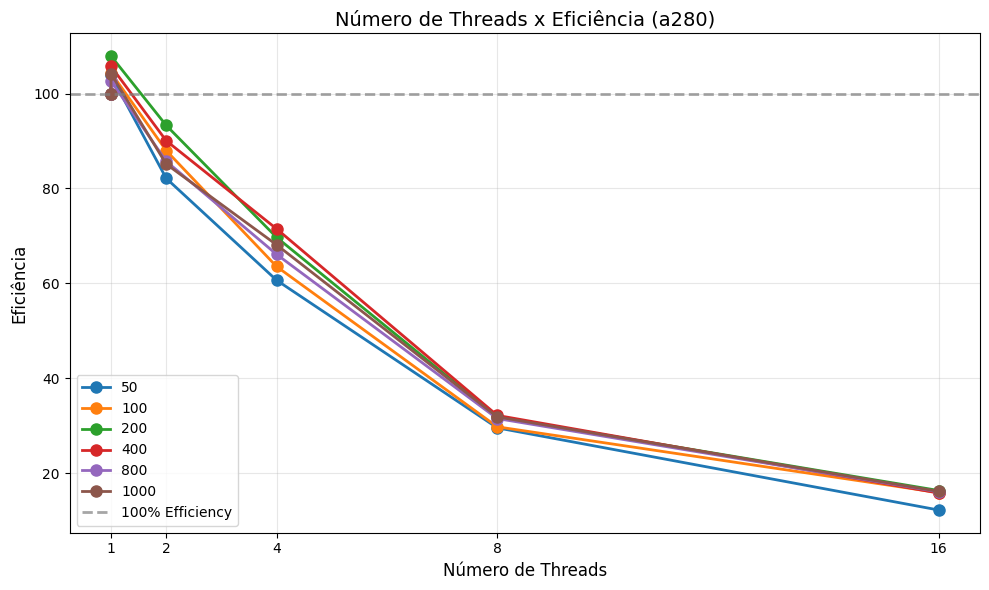

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

for population_size in pop_sizes:
    pop_data = grouped_a280[grouped_a280['population_size'] == population_size]
    
    ax.plot(pop_data['threads'], 
            pop_data['efficiency'],
            marker='o', 
            linewidth=2,
            markersize=8,
            label=population_size)
    
ax.axhline(y=100, 
        linestyle='--', 
        linewidth=2,
        color='gray', 
        alpha=0.7,
        label='100% Efficiency')

ax.set_xlabel('Número de Threads', fontsize=12)
ax.set_ylabel('Eficiência', fontsize=12)
ax.set_title('Número de Threads x Eficiência (a280)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xticks(thread_counts)
plt.tight_layout()

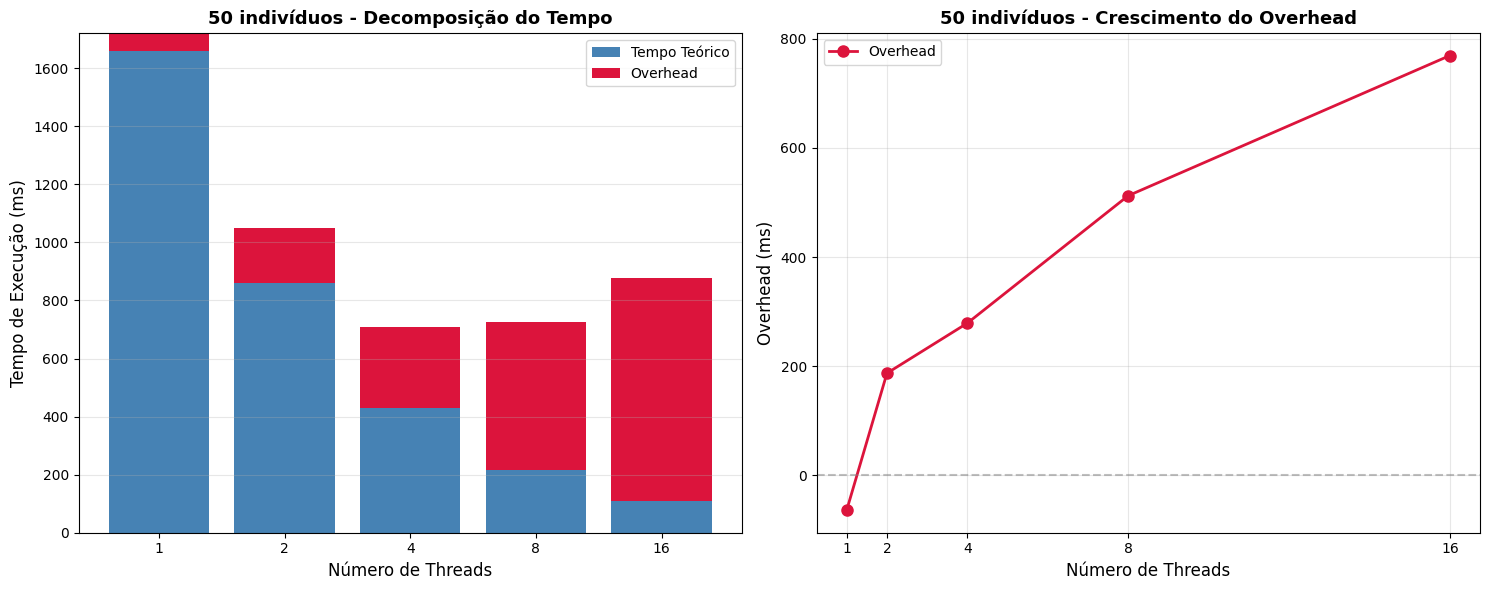

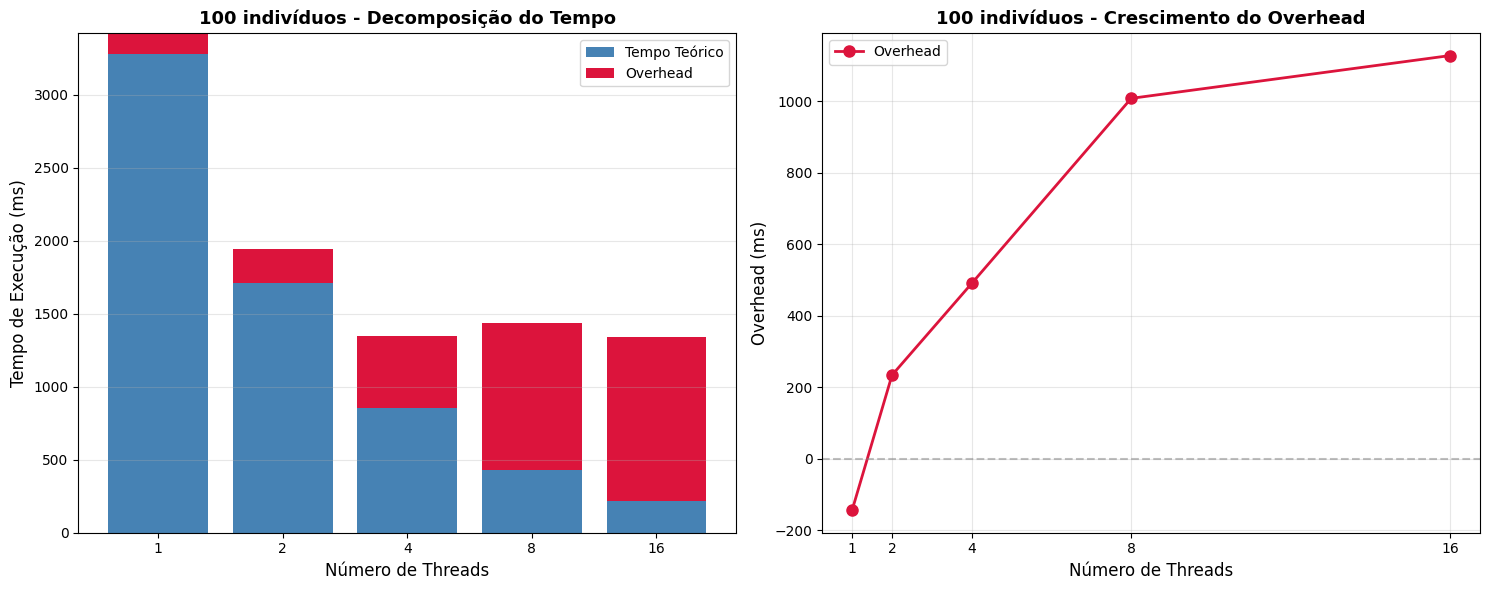

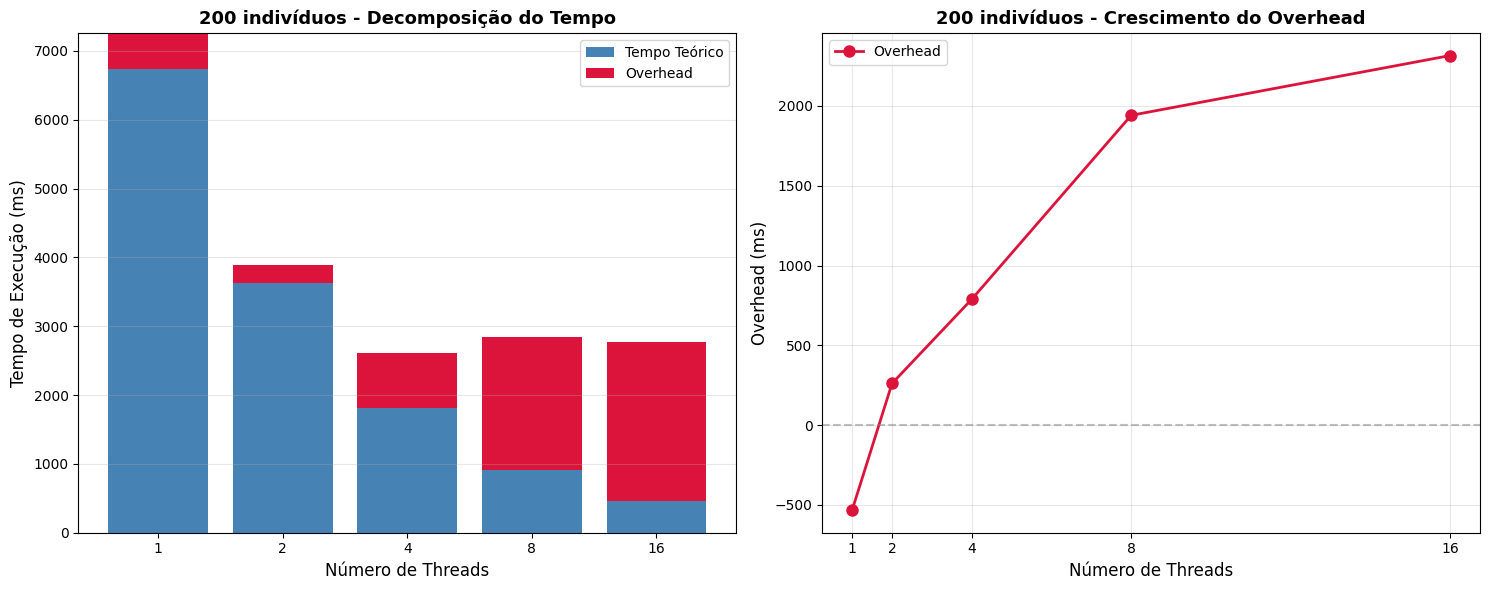

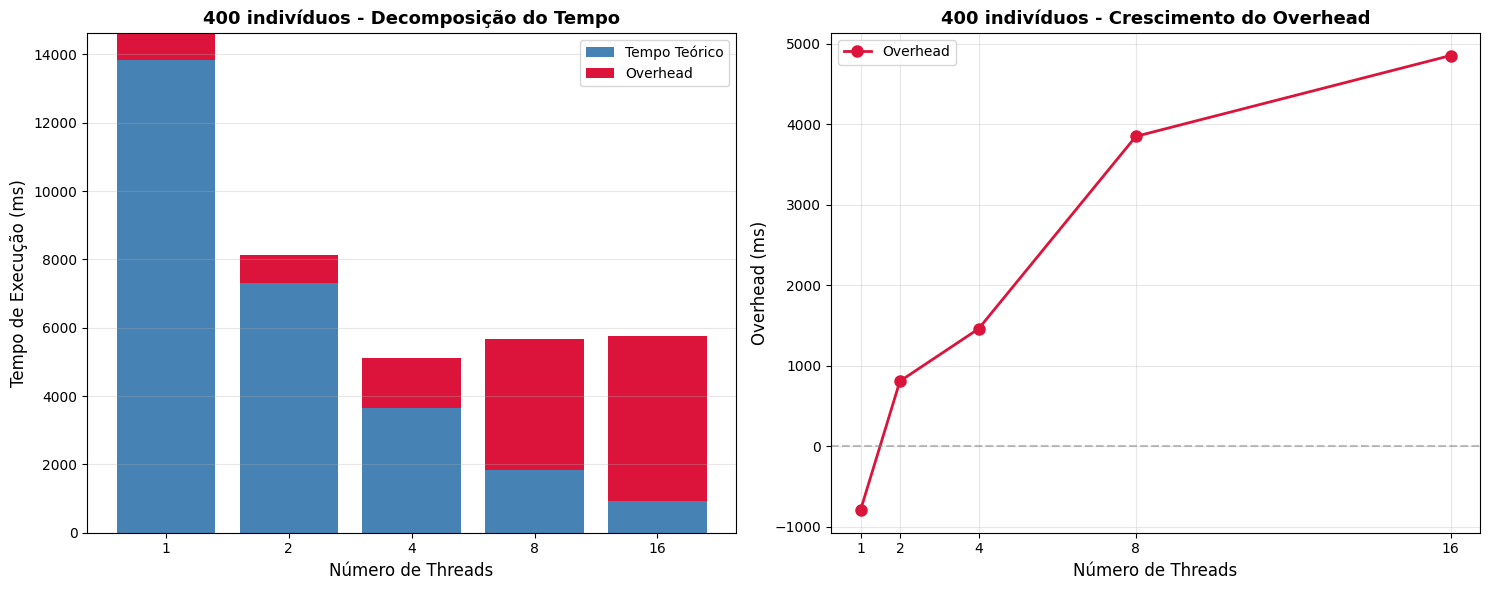

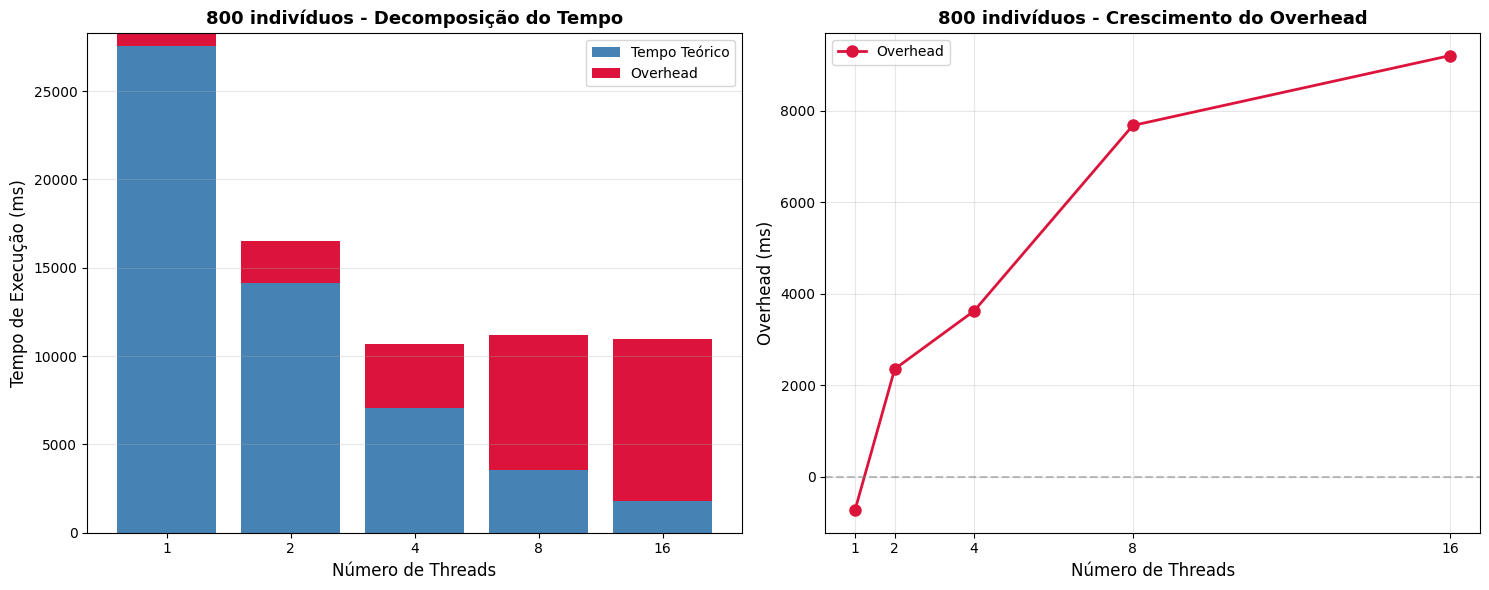

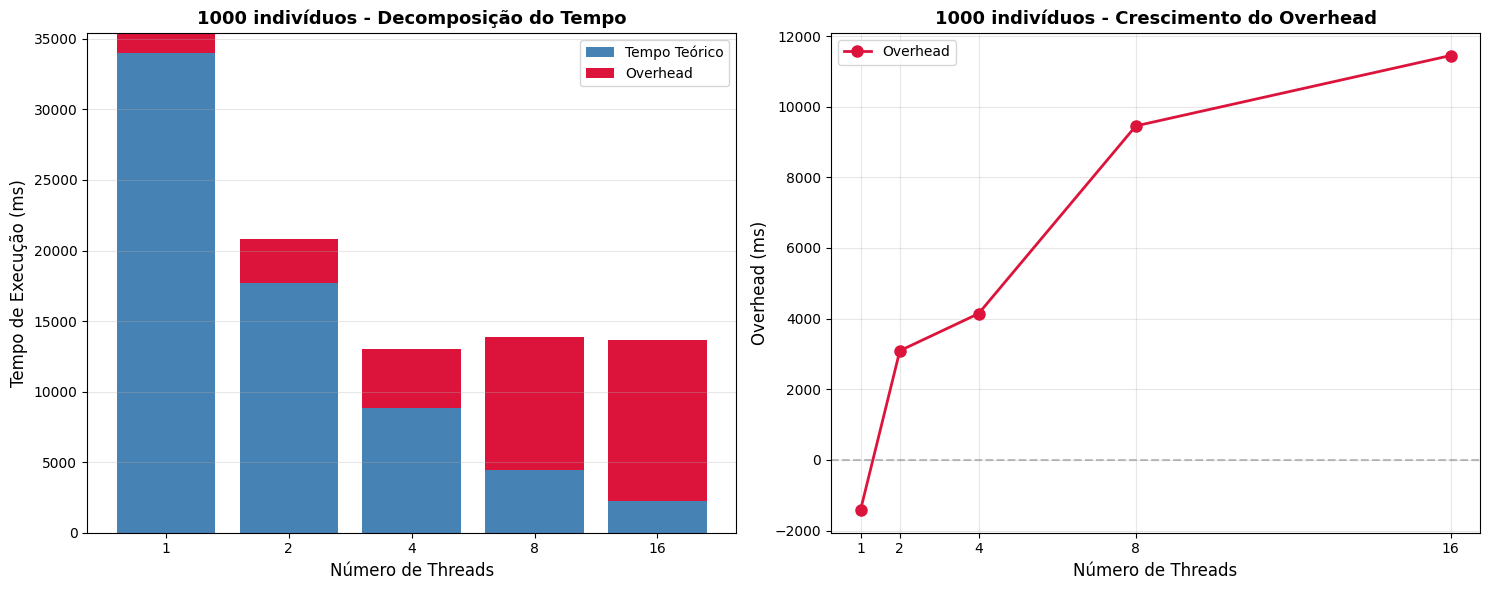

In [ ]:
for population_size in pop_sizes:
    pop_data = parallel_grouped_a280[parallel_grouped_a280['population_size'] == population_size]
    
    if len(pop_data) == 0:
        print(f"Skipping {population_size}: no parallel data")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    threads = pop_data['threads'].values
    ideal = pop_data['ideal_time'].values
    overhead = pop_data['overhead'].values
    
    x_pos = range(len(threads))
    
    # ===== PLOT 1: Stacked Bar Chart =====
    ax1.bar(x_pos, ideal, label='Tempo Teórico', color='steelblue')
    ax1.bar(x_pos, overhead, bottom=ideal, label='Overhead', color='crimson')
    
    ax1.set_xlabel('Número de Threads', fontsize=12)
    ax1.set_ylabel('Tempo de Execução (ms)', fontsize=12)
    ax1.set_title(f'{population_size} indivíduos - Decomposição do Tempo', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(threads)
    
    # ===== PLOT 2: Overhead Line Graph =====
    ax2.plot(threads, overhead,
             marker='o',
             linewidth=2,
             markersize=8,
             color='crimson',
             label='Overhead')
    
    ax2.set_xlabel('Número de Threads', fontsize=12)
    ax2.set_ylabel('Overhead (ms)', fontsize=12)
    ax2.set_title(f'{population_size} indivíduos - Crescimento do Overhead', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(threads)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()